In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
# %matplotlib notebook

from small_susc import make_layout_small_susc

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import superscreen as sc

In [2]:
device = make_layout_small_susc()

In [3]:
device

Device(
    "susceptometer_100nm", 
    layers=[
        Layer("W2", Lambda=0.032, thickness=0.200, london_lambda=0.080, z0=0.100), 
        Layer("W1", Lambda=0.064, thickness=0.100, london_lambda=0.080, z0=0.380), 
        Layer("BE", Lambda=0.040, thickness=0.160, london_lambda=0.080, z0=0.660),
    ], 
    films=[
        Polygon("fc", layer="BE", points=ndarray[shape=(27, 2)]), 
        Polygon("pl_shield2", layer="BE", points=ndarray[shape=(6, 2)]), 
        Polygon("fc_shield", layer="W1", points=ndarray[shape=(10, 2)]), 
        Polygon("pl", layer="W1", points=ndarray[shape=(19, 2)]), 
        Polygon("pl_shield", layer="W2", points=ndarray[shape=(6, 2)]),
    ], 
    holes=[
        Polygon("fc_center", layer="BE", points=ndarray[shape=(28, 2)]),
    ], 
    abstract_regions=[
        Polygon("bounding_box", layer="BE", points=ndarray[shape=(4, 2)]), 
        Polygon("pl_hull", layer="W1", points=ndarray[shape=(12, 2)]),
    ], 
    length_units="um",
)

In [4]:
device = make_layout_small_susc()
device.make_mesh(min_triangles=8000, optimesh_steps=200)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 8805 triangles.
INFO:superscreen.device:Finished generating mesh with 4525 points and 8805 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


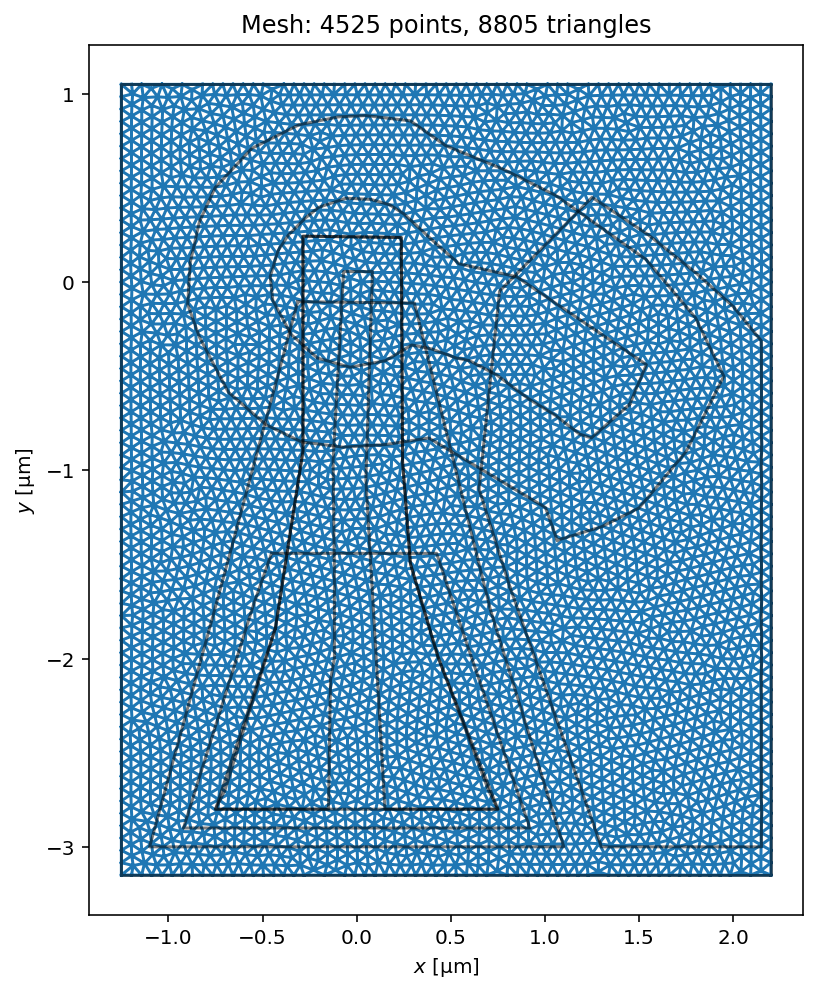

In [5]:
ax = device.plot_mesh()
ax = device.plot_polygons(ax=ax, color='k', alpha=0.5, legend=False)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [6]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=11,
    coupled=True,
)

INFO:superscreen.brandt:Calculating W2 response to applied field.
INFO:superscreen.brandt:Calculating W1 response to applied field.
INFO:superscreen.brandt:Calculating BE response to applied field.
INFO:superscreen.brandt:Calculating screening field at W2 from W1 (1/11).
INFO:superscreen.brandt:Calculating screening field at W2 from BE (1/11).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (1/11).
INFO:superscreen.brandt:Calculating screening field at W1 from BE (1/11).
INFO:superscreen.brandt:Calculating screening field at BE from W2 (1/11).
INFO:superscreen.brandt:Calculating screening field at BE from W1 (1/11).
INFO:superscreen.brandt:Calculating W2 response to applied field and screening field from other layers (1/11).
INFO:superscreen.brandt:Calculating W1 response to applied field and screening field from other layers (1/11).
INFO:superscreen.brandt:Calculating BE response to applied field and screening field from other layers (1/11).
INFO:superscreen.brandt:C

INFO:superscreen.brandt:Calculating screening field at W2 from BE (10/11).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (10/11).
INFO:superscreen.brandt:Calculating screening field at W1 from BE (10/11).
INFO:superscreen.brandt:Calculating screening field at BE from W2 (10/11).
INFO:superscreen.brandt:Calculating screening field at BE from W1 (10/11).
INFO:superscreen.brandt:Calculating W2 response to applied field and screening field from other layers (10/11).
INFO:superscreen.brandt:Calculating W1 response to applied field and screening field from other layers (10/11).
INFO:superscreen.brandt:Calculating BE response to applied field and screening field from other layers (10/11).
INFO:superscreen.brandt:Calculating screening field at W2 from W1 (11/11).
INFO:superscreen.brandt:Calculating screening field at W2 from BE (11/11).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (11/11).
INFO:superscreen.brandt:Calculating screening field at W1 from B

In [7]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
    
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [8]:
display(df)

,fc,pl_shield2,fc_shield,pl,pl_shield,fc_center,bounding_box,pl_hull
Iteration,,,,,,,,
0,2.369358,0.000000,0.000000,0.000000,0.000000,2.200121,0.768389,0.000000
1,2.369358,0.000000,0.036718,0.031505,0.009362,2.200121,0.768389,0.071870
2,2.345842,0.000863,0.036685,0.031746,0.010373,2.181934,0.752494,0.072341
3,2.345835,0.000803,0.036821,0.031551,0.010315,2.181931,0.752253,0.071757
4,2.345781,0.000814,0.036818,0.031568,0.010325,2.181897,0.752207,0.071808
5,2.345782,0.000813,0.036819,0.031565,0.010324,2.181897,0.752205,0.071800
6,2.345781,0.000813,0.036819,0.031565,0.010324,2.181897,0.752205,0.071801
7,2.345781,0.000813,0.036819,0.031565,0.010324,2.181897,0.752205,0.071801
8,2.345781,0.000813,0.036819,0.031565,0.010324,2.181897,0.752205,0.071801


<ipython-input-9-91bf377079e5>:5: RuntimeWarning: divide by zero encountered in true_divide
  ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]


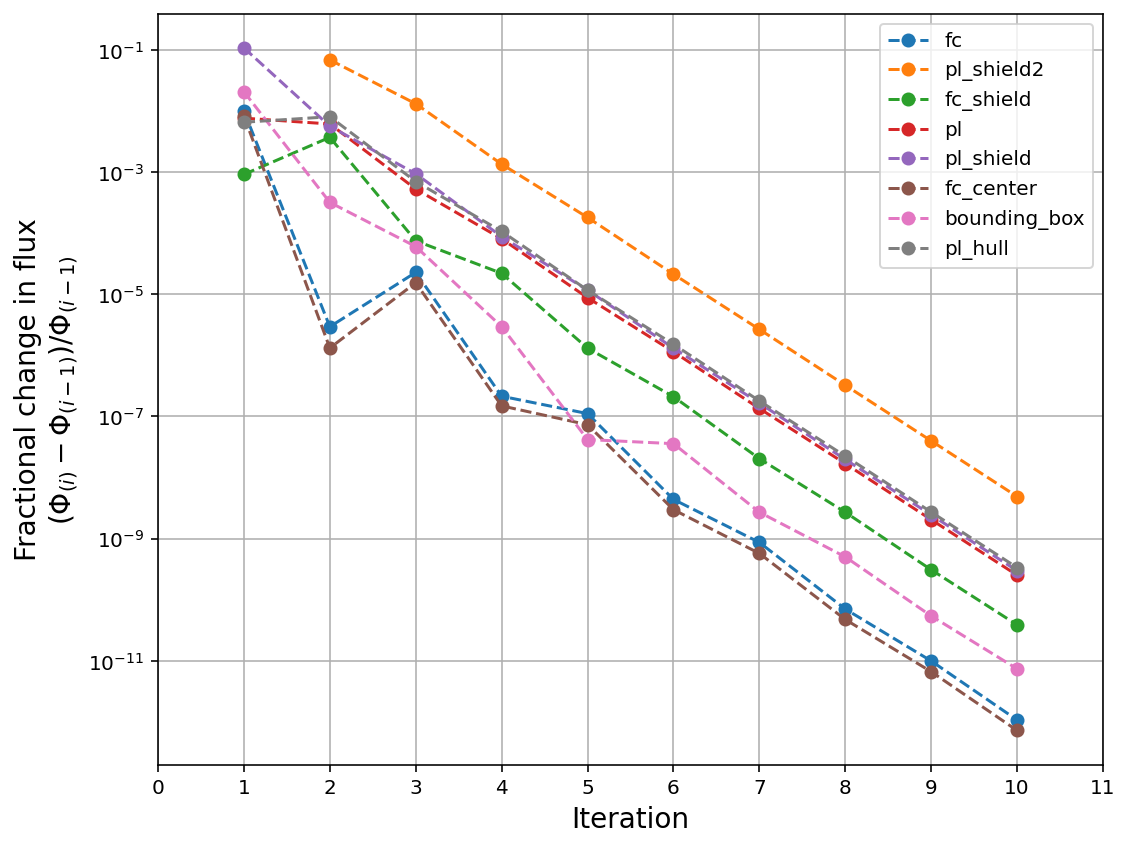

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} - \\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_yscale("log")
ax.set_xticks(range(len(df)))
ax.legend(loc=0)
fig.tight_layout()

In [10]:
flux = solutions[-1].polygon_flux()
print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(f"{(flux['pl_hull'] / device.ureg(circulating_currents['fc_center'])).to('Phi_0/A'):.3f~P}")

7.180×10⁻² Φ_0
71.801 Φ_0/A


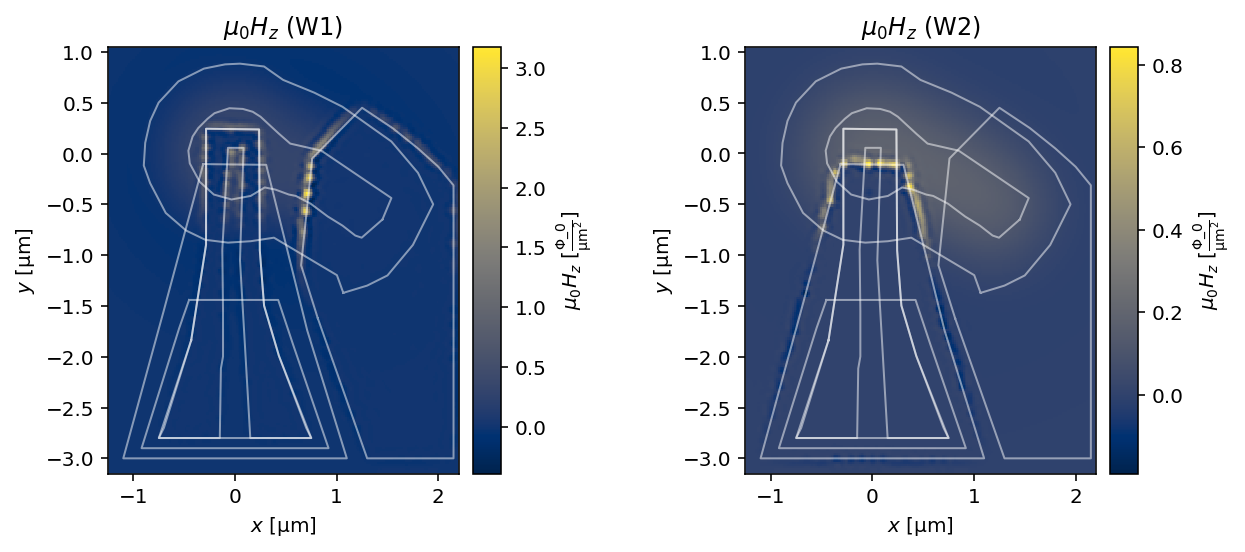

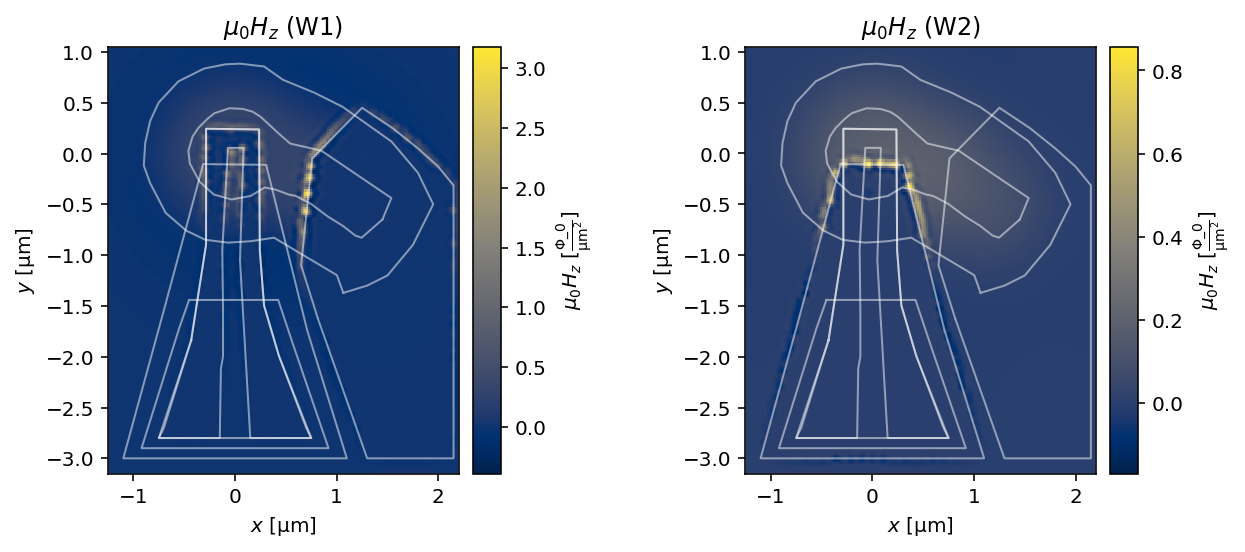

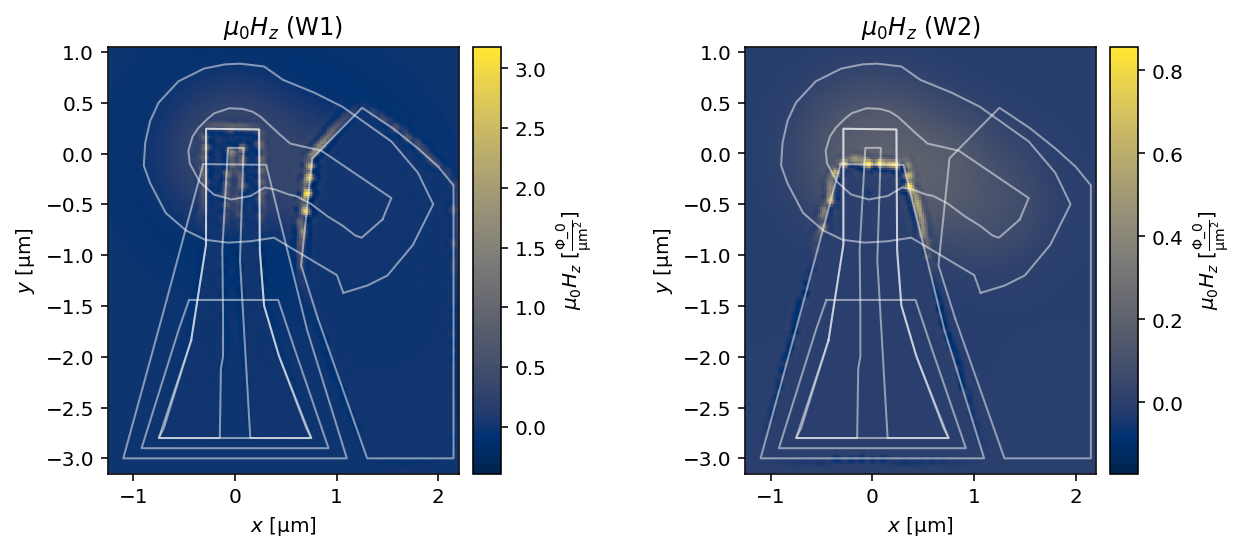

In [11]:
for solution in solutions[1:4]:
    fig, axes = sc.plot_fields(
        solution,
        layers=["W1", "W2"],
        figsize=(9,4),
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='w', lw=1, alpha=0.5)

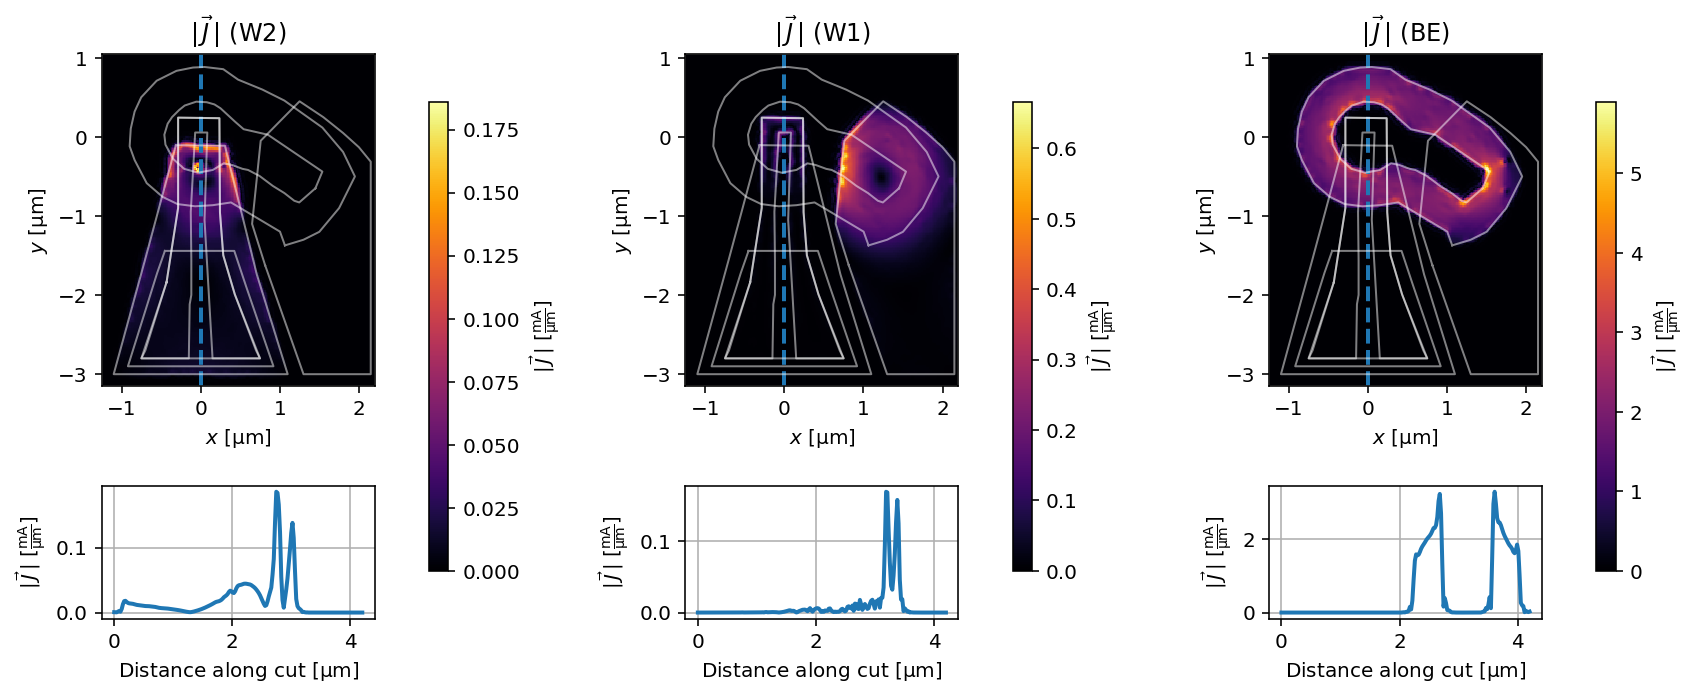

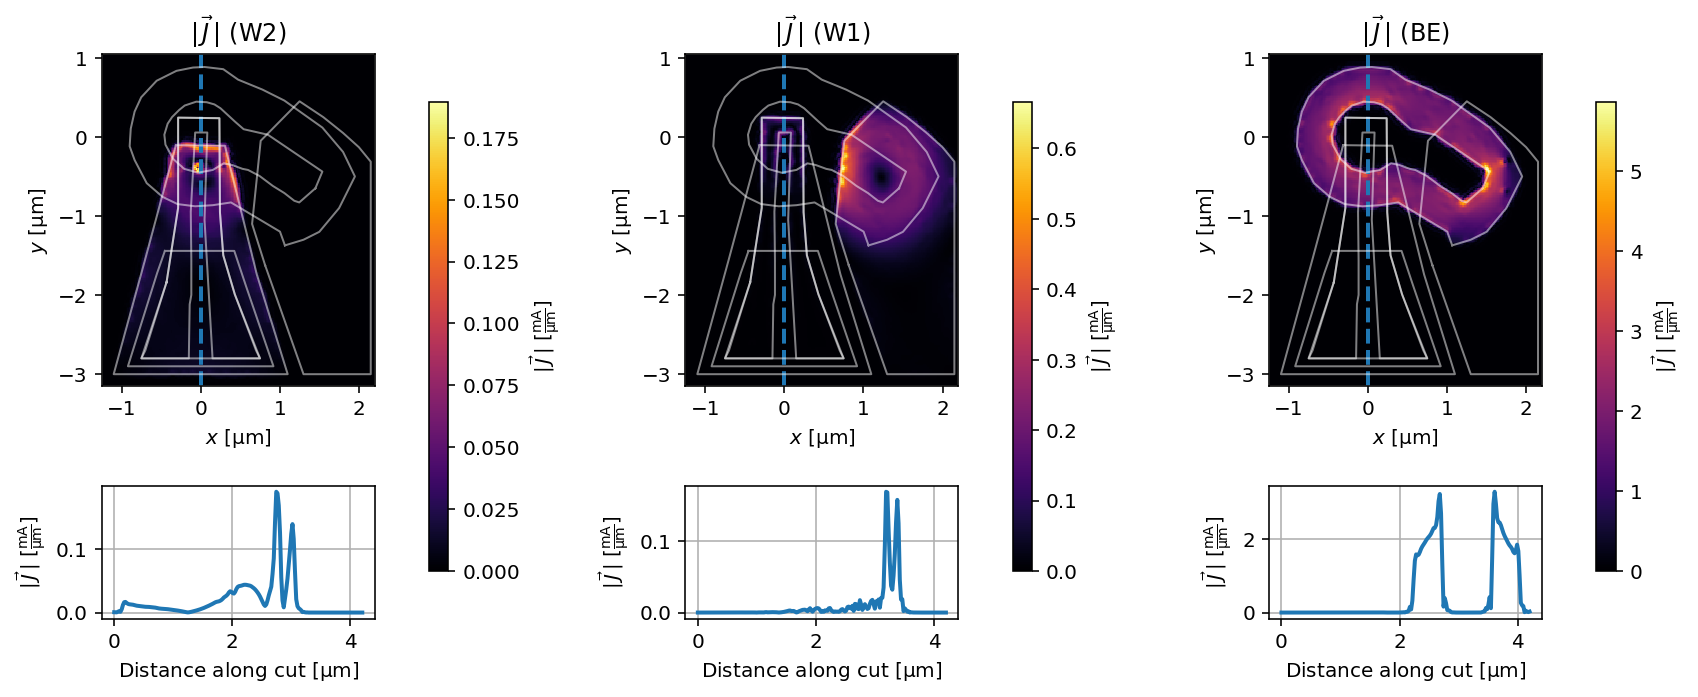

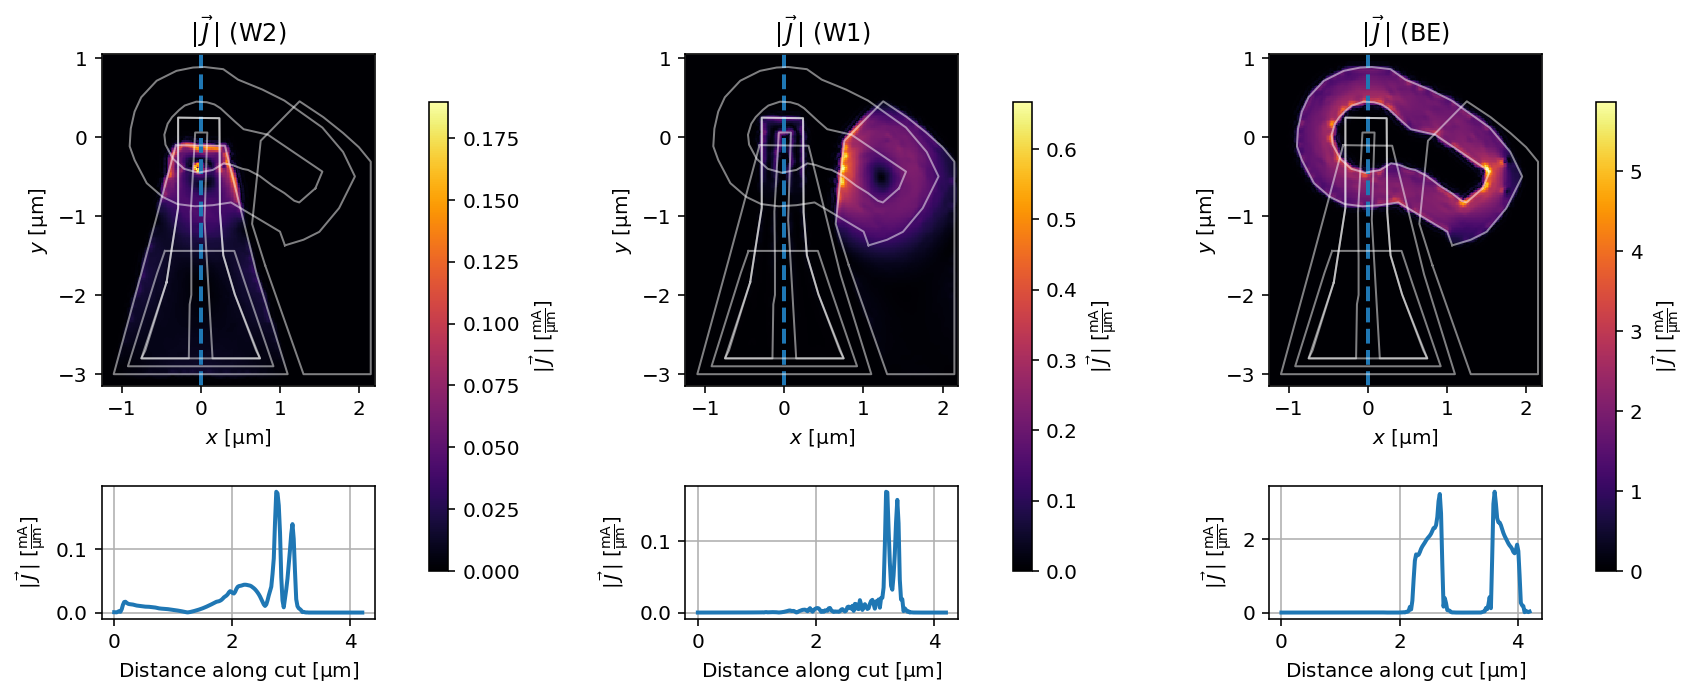

In [12]:
for solution in solutions[1:4]:
    fig, axes = sc.plot_currents(
        solution,
        figsize=(12,5),
        streamplot=False,
        units="mA/um",
        cross_section_xs=0,
        cross_section_angle=0,
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='w', lw=1, alpha=0.5)